<a href="https://colab.research.google.com/github/Manuelstv/Manuelstv/blob/main/new_0_00083_0_9305_deepshadows_image_classification_with_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

0.9122 -0.00075

# Setup

In [1]:
pip install -U tensorflow-addons

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [3]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#X_pos = np.float64(np.load("/content/drive/My Drive/datasets/LSBGs.npy"))
#X_neg = np.float64(np.load("/content/drive/My Drive/datasets/negatives2.npy"))

In [9]:
#x_train = np.zeros((30000,64,64,3))
#x_train[0:15000] = X_pos[0:15000]
#x_train[15000:30000] = X_neg[0:15000]
#np.save('x_train', x_train)
y_train = np.zeros(30000)
y_train[0:15000] = np.ones(15000)
x_train = np.float64(np.load("/content/x_train.npy"))
x_train, y_train = shuffle(x_train, y_train)

#x_val = np.zeros((5000,64,64,3))
#x_val[0:2500] = X_pos[15000:17500]
#x_val[2500:5000] = X_neg[15000:17500]
#np.save('x_val', x_val)
y_val = np.zeros(5000)
y_val[0:2500] = np.ones(2500)
x_val = np.float64(np.load("/content/x_val.npy"))
x_val, y_val = shuffle(x_val, y_val)

#x_test = np.zeros((4995,64,64,3))
#x_test[0:2495] = X_pos[17500:19995]
#x_test[2495:4995] = X_neg[17500:20000]
#np.save('x_test', x_test)
y_test = np.zeros(4995)
y_test[0:2495] = np.ones(2495)
x_test = np.float64(np.load("/content/x_test.npy"))
x_test, y_test = shuffle(x_test, y_test)

**lsbgs examples**

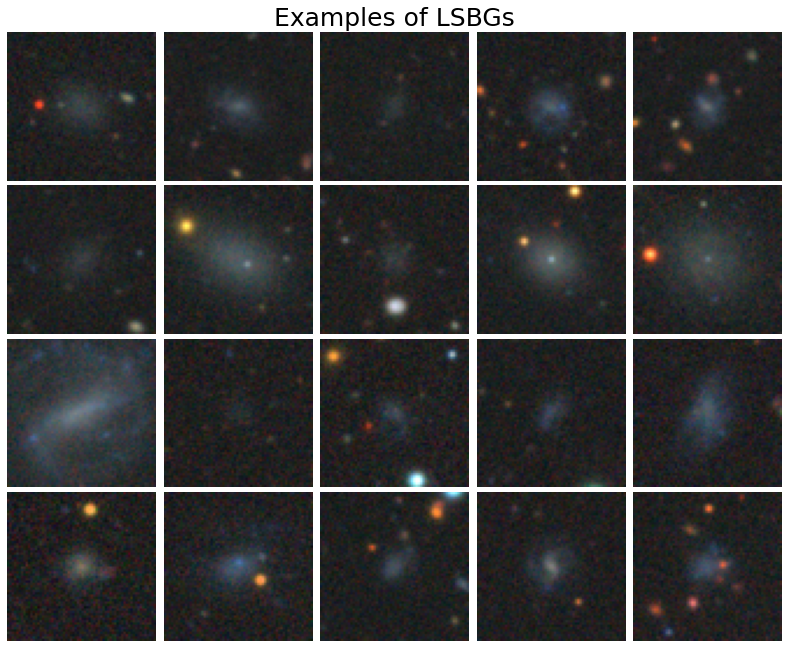

In [6]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i]/255)
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
plt.show()

**artifacts examples**

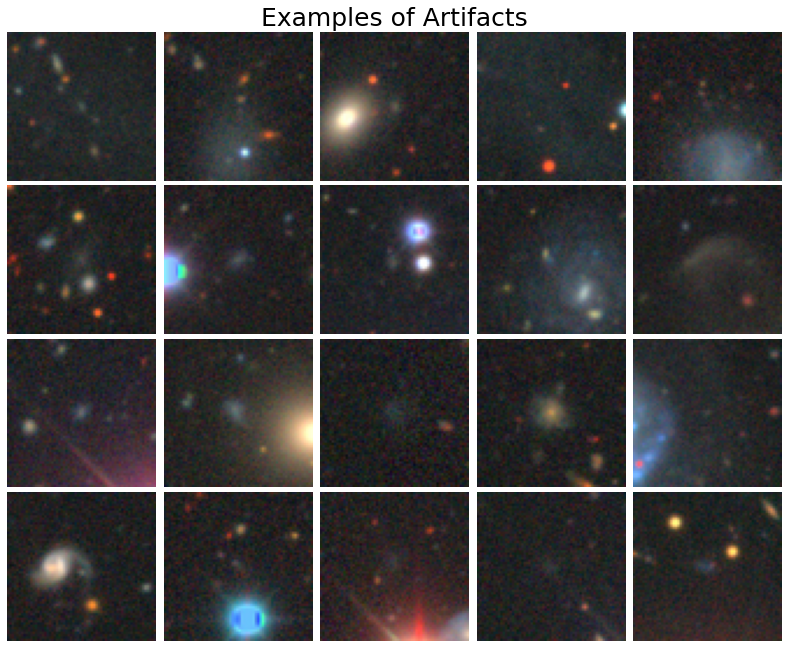

In [7]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i+15000]/255)
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
plt.show()

## Prepare the data

In [10]:
num_classes = 2
input_shape = (64, 64, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_test shape: {y_val.shape}")

x_train shape: (30000, 64, 64, 3) - y_train shape: (30000,)
x_test shape: (4995, 64, 64, 3) - y_test shape: (4995,)
x_val shape: (5000, 64, 64, 3) - y_test shape: (5000,)


## Configure the hyperparameters

In [11]:
learning_rate = 0.00083
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Use data augmentation

In [12]:
#layers.RandomFlip("horizontal_and_vertical")

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
           height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


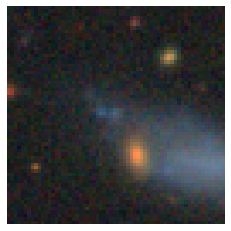

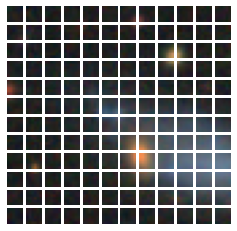

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/30


In [ ]:
# scikit-learn for Machine Learn

# Preprocessing
from sklearn.preprocessing import StandardScaler #Standar scaler for standardization
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
# Classifiers
from sklearn.svm import SVC #Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier as RF #Random Forests
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

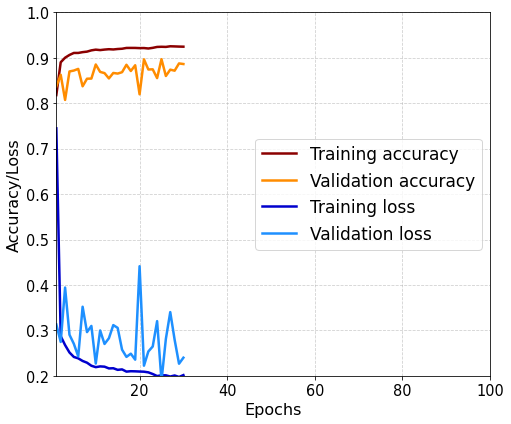

In [ ]:
Epochs = np.arange(1,31,1)
history_dict = history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy/Loss',fontsize=16)
plt.xlim(1,100)
plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Acc_Loss.pdf")
#files.download("/content/drive/My Drive/Plots/Acc_Loss.pdf")
plt.show()

In [ ]:
# Predict on test data 
#y_pred_DL= np.argmax(vit_classifier.predict(x_test),axis=1).astype("int32")
#y_pred_DL = (vit_classifier.predict(x_test) > 0.5).astype("int32")
y_pred_DL = (vit_classifier.predict(x_test)[:,1] > 0.5).astype("int32")
# Print classification metrics 
print("Accuracy score for DL:",accuracy_score(y_test,y_pred_DL))
print("Precision score for DL:",precision_score(y_test,y_pred_DL))
print("Recall score for DL:",recall_score(y_test,y_pred_DL))
#print("AUC score for DL:",roc_auc_score(y_test,y_pred_DL))#Not correct, see belo

Accuracy score for DL: 0.9035035035035035
Precision score for DL: 0.9408672798948752
Recall score for DL: 0.8609218436873748


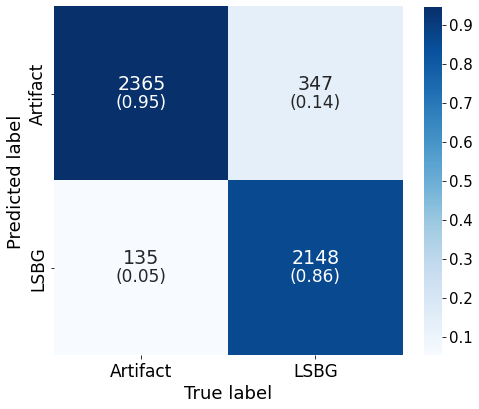

In [ ]:
# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_DL)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])

con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']
# ==============================================
# ==============================================


plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Conf_matrix_DL.pdf")
#files.download("/content/drive/My Drive/Plots/Conf_matrix_DL.pdf")
plt.show()

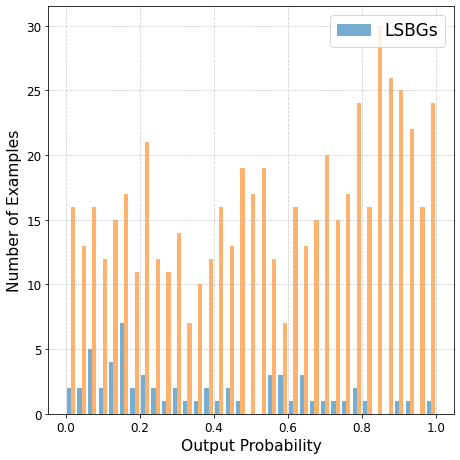

In [ ]:
# First let's predict probabilities on the test set
scores_DL = vit_classifier.predict(x_test)

plt.figure(figsize = (6.5,6.5))

plt.hist(scores_DL[y_test==1.0],range=[0,1],bins=35,alpha=0.6,density=False,label='LSBGs')
#plt.hist(scores_DL[y_test==0.0],range=[0,1],bins=35,alpha=0.6,density=False,label='Artifacts')
# ==============================================================================
# ==============================================================================
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=17)

plt.xlabel("Output Probability", fontsize=15.5)
plt.ylabel("Number of Examples", fontsize=15.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/DL_probas.pdf")
#files.download("/content/drive/My Drive/Plots/DL_probas.pdf")
plt.show()

In [ ]:
X_misc_Art = x_test[(scores_DL[:,1]>0.8)&(y_test==0.0)] #Artefacts classified as LSBGs
X_misc_LSBG = x_test[(scores_DL[:,1]<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
# ==============================================================================
# ==============================================================================
# Get probabilities/scores 
P_misc_Art = scores_DL[(scores_DL[:,1]>0.8)&(y_test==0.0)] #Artefacts classified as LSBGs
P_misc_LSBG = scores_DL[(scores_DL[:,1]<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
# ==============================================================================
# ==============================================================================
# Print numbers of each one
print(len(P_misc_Art),len(P_misc_LSBG))

90 201


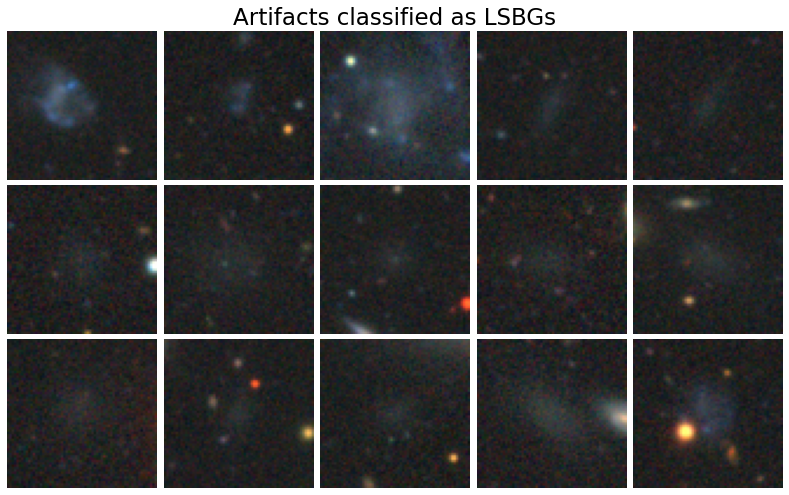

In [ ]:
# Plot them
n_rows = 3
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Artifacts classified as LSBGs",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_LSBG[i]/255)
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Misclass_Art_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_Art_Examples.pdf")
plt.show()

In [ ]:
X_corr_Art = x_test[(scores_DL[:,1]>0.4)&(scores_DL[:,1]<0.5)&(y_test==0.0)] #Artifacts classified as LSBGs
X_corr_LSBG = x_test[(scores_DL[:,1]>0.5)&(scores_DL[:,1]<0.6)&(y_test==1.0)] #LSBGs classified as LSBGs
# ==============================================================================
# ==============================================================================
# Get probabilities/scores 
P_corr_Art = scores_DL[(scores_DL[:,1]>0.4)&(scores_DL[:,1]<0.5)&(y_test==0.0)] #Artifacts classified as Artefacts
P_corr_LSBG = scores_DL[(scores_DL[:,1]>0.5)&(scores_DL[:,1]<0.6)&(y_test==1.0)] #LSBGs classified as LSBGs
# ==============================================================================
# ==============================================================================
# Print numbers of each one
print(len(P_corr_Art),len(P_corr_LSBG))

10 44


In [ ]:
def bootstrap(y_pred, y_pred_proba,y_test_loc):
  n_bootstraps = 1000 

  # Classification metrics that we want to estimate
  # ===============================================================
  boot_accuracy = np.zeros(n_bootstraps)
  boot_precision = np.zeros(n_bootstraps) #Also known as purity
  boot_recall = np.zeros(n_bootstraps) # Also known as completeness
  boot_tprs = np.zeros((n_bootstraps,200)) # True positive rates
  boot_auc = np.zeros(n_bootstraps) # AUC
  fprs = np.linspace(0,1,200) # False positive rates
  # ===============================================================
  # ===============================================================
  indices = np.arange(len(y_test_loc))

  for i in range(n_bootstraps):
    # Get local indices by resampling
    ind_loc = resample(indices, n_samples=len(indices), replace=True)

    # ================================================================================
    # Now get "local" test samples, meaning those resulting from resampling

    y_pred_loc = y_pred[ind_loc]  #Prediction 
    y_pred_prob_loc = y_pred_proba[ind_loc] #Probability prediction
    y_true_loc = y_test_loc[ind_loc] #True labels of the test set

    # ================================================================================
    # ================================================================================
    # Now estimate the evaluation metrics for the current resampling

    boot_accuracy[i] = accuracy_score(y_true_loc, y_pred_loc) #Accuracy
    boot_precision[i] = precision_score(y_true_loc, y_pred_loc) #Precision
    boot_recall[i] = recall_score(y_true_loc, y_pred_loc) #Recall
    boot_auc[i] = roc_auc_score(y_true_loc, y_pred_prob_loc[:,0]) #AUC score 

    # And now for the true positive rate, in order to get the errors on the ROC curve

    fpr_loc, tpr_loc, thresholds_loc = roc_curve(y_true_loc, y_pred_prob_loc[:,1], pos_label=1.0)
    fpr_unique, ind_unique = np.unique(fpr_loc,return_index=True)
    tpr_unique = tpr_loc[ind_unique]

    # interpolate the false positive - true positives
    interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
    boot_tprs[i,:] = interp(fprs)

  # =================================================================================
  # return them 
  return boot_accuracy,boot_precision,boot_recall,boot_auc,boot_tprs

In [ ]:
# For Deep Learning - Deep Shadows 
scores_DL = vit_classifier.predict(x_test)

In [ ]:
from scipy import interpolate
acc_boot_DL, prec_boot_DL, rec_boot_DL, auc_boot_DL, tprs_boot_DL = bootstrap(y_pred_DL, scores_DL, y_test)

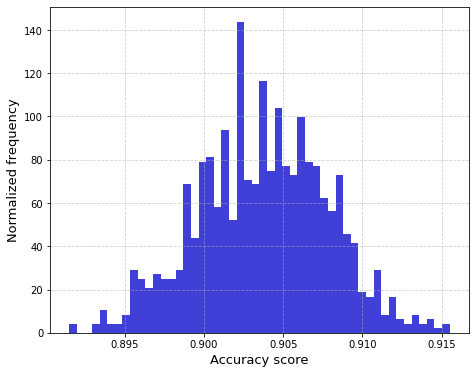

In [ ]:
# For Accuracy - note, the plot is just for our inspection, we are not going to show it in the paper 
plt.figure(figsize=(7.5, 6.0))

plt.hist(acc_boot_DL, bins=50,color='mediumblue',alpha=0.75, density=True)
plt.grid(ls='--',alpha=0.6)

plt.xlabel('Accuracy score',fontsize=13);plt.ylabel('Normalized frequency',fontsize=13)
plt.show()

In [ ]:
# Precision

# sort
prec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_prec_DL = prec_boot_DL[int(0.025 * len(prec_boot_DL))]
conf_upper_prec_DL = prec_boot_DL[int(0.975 * len(prec_boot_DL))]
# Print confidence interval
print("Precision confidence intervals, DeepShadows:",conf_lower_prec_DL,conf_upper_prec_DL)
# ==============================================================================
# ==============================================================================
# Recall

# sort
rec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_rec_DL = rec_boot_DL[int(0.025 * len(rec_boot_DL))]
conf_upper_rec_DL = rec_boot_DL[int(0.975 * len(rec_boot_DL))]
# Print confidence interval
print("Recall confidence intervals, DeepShadows:",conf_lower_rec_DL,conf_upper_rec_DL)
# ==============================================================================
# ==============================================================================
# AUC score

# sort
auc_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_auc_DL = auc_boot_DL[int(0.025 * len(auc_boot_DL))]
conf_upper_auc_DL = auc_boot_DL[int(0.975 * len(auc_boot_DL))]
# Print confidence interval
print("AUC confidence intervals, DeepShadows:",conf_lower_auc_DL,conf_upper_auc_DL)

Precision confidence intervals, DeepShadows: 0.9315307457479285 0.9510797708241516
Recall confidence intervals, DeepShadows: 0.8485702778896497 0.8738336713995943
AUC confidence intervals, DeepShadows: 0.03425043101720059 0.04642069965479627


In [ ]:
# For Deep Learning - Deep Shadows 
scores_DL = vit_classifier.predict(x_test)

In [ ]:
# For Deep Learning - Deep Shadows 
fpr_DL, tpr_DL, thresholds_DL = roc_curve(y_test, scores_DL[:,1], pos_label=1.0)

In [ ]:
fprs = np.linspace(0,1,200) # False positive rates

# For Deep Learning - Deep shadows

# Create empty arrays - to store the intervals
lower_tprs_DL = np.zeros(200)
upper_tprs_DL = np.zeros(200)

for i in range(200):
  tprs_boot_DL_loc = tprs_boot_DL[:,i]

  #sort it
  tprs_boot_DL_loc.sort()
  # Compute the lower and upper bound of the 95% confidence interval
  lower_tprs_DL[i] = tprs_boot_DL_loc[int(0.025 * len(tprs_boot_DL_loc))]
  upper_tprs_DL[i] = tprs_boot_DL_loc[int(0.975 * len(tprs_boot_DL_loc))]  

In [ ]:
# AUC DL
AUC_DL = roc_auc_score(y_test, scores_DL[:,1])
# ========================================================
print("AUC score for DL:",AUC_DL)

AUC score for DL: 0.9699139879759519


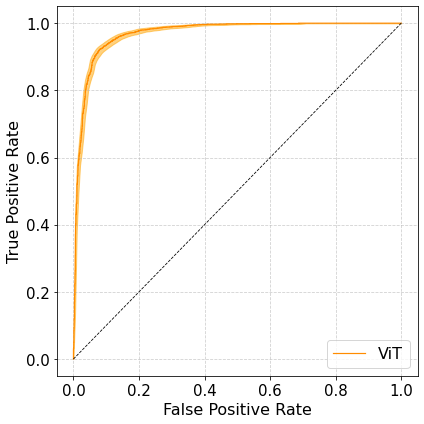

In [ ]:
x = np.linspace(0,1,100)
plt.figure(figsize = (6.0,6.0))

# Deep Learning and confidence interval
plt.plot(fpr_DL,tpr_DL,c='darkorange',linewidth=1.2, label='ViT')
plt.fill_between(fprs,lower_tprs_DL, upper_tprs_DL,color='orange',rasterized=True,alpha=0.5)

plt.plot(x,x, c='k',ls='--',linewidth=0.8)
plt.grid(ls='--', alpha=0.6)

#plt.title('ROC curve')
plt.xlabel('False Positive Rate',fontsize=16);plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(frameon=True, loc='lower right', fontsize=16)
plt.tick_params(axis='both', labelsize=15)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/ROC_curves.pdf")
#files.download("/content/drive/My Drive/Plots/ROC_curves.pdf")
plt.show()

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.